In [133]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
import numpy as np
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import glob
import plotly.express as px

# Read in all the data

Functions to get the common names of the proteins: 

In [134]:
# function to match gene symbols to monomer ids
def get_gene_symbols_for_monomer_ids():
	"""
	Extracts the gene symbols for each monomer id in the model.
	Returns: a dictionary mapping monomer ids to gene symbols.
	Code adapted from convert_to_flat.py.
	"""
	RNAS_FILE = os.path.join(ROOT_PATH, 'reconstruction', 'ecoli',
								 'flat', 'rnas.tsv')
	with (io.open(RNAS_FILE, 'rb') as f):
		reader = tsv.reader(f, delimiter='\t')
		headers = next(reader)
		while headers[0].startswith('#'):
			headers = next(reader)

		# extract relevant information
		gene_symbol_index = headers.index('common_name')
		protein_id_index = headers.index('monomer_ids')
		monomer_ids_to_gene_symbols = {}
		for line in reader:
			gene_symbol = line[gene_symbol_index]
			protein_id = list(
				line[protein_id_index][2:-2].split('", "'))[0]
			monomer_ids_to_gene_symbols[protein_id] = gene_symbol

	return monomer_ids_to_gene_symbols

def get_common_name(protein_id):
    """
    Get the common name of a protein given its monomer id.
    Args:
        protein_id: the name of the monomer

    Returns:
        common_name: The common name of the protein.

    """
    if '[' in protein_id:
        protein_id = protein_id[:-3]  # subtract the compartment
        
    if protein_id == 'NG-GFP-MONOMER':
        print('NEW GENE PRESENT')
    else:
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    return common_name

# Generate the data table with all the infomration needed

Note that here is where the current_sequence and CLNE_sequence are defined, as well as all the files read in to make the tables!

In [135]:
# read in the CLNE1 half life data: 
CLNE1_HLs = "out/CLNE1/kb_plot_out/protein_half_lives.tsv"
CLNE1_HLs = pd.read_csv(CLNE1_HLs, sep='\t')
CLNE1_HLs = CLNE1_HLs.rename(columns={"half_life_(min)": "original_half_life"})
CLNE1_HLs = CLNE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# read in the CLClim3NE1 half life data:
CLClim3NE1_HLs = "out/CLClim3NE1/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs = CLClim3NE1_HLs.rename(columns={"half_life_(min)": "new_half_life"})
CLClim3NE1_HLs = CLClim3NE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# merge the two together: 
combined_df = pd.merge(CLClim3NE1_HLs, CLNE1_HLs, on='monomer_id', how='inner')

# add the common names to the dataframe:
combined_df['common_name'] = None
for index, row in combined_df.iterrows():
    common_name = get_common_name(row['monomer_id'])
    combined_df.at[index, 'common_name'] = common_name

# add the counts data: 
current_sequence = "CLClim3NE2"
CLNE_sequence = "CLNE_11192024"
CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLClimNE_log_data['Monomer ID'] = CLClimNE_log_data['Monomer ID'].str[:-3]

# do the same for the 2020 model:
CLNE_log_data = pd.read_csv('/Users/miagrahn/wcEcoli/out/CLNE_11192024/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data = CLClimNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data = CLClimNE_log_data.set_index("Monomer ID")
# CLNE_log_data = CLNE_log_data.reset_index()
# CLClimNE_log_data = CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_log_data.join(CLClimNE_log_data, on="Monomer ID", how="inner")
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.rename(columns={"Monomer ID": "monomer_id"})
#CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.set_index("monomer_id")


# merge into combined_df:
combined_df = pd.merge(combined_df, CLNE_CLClimNE_log_data, on='monomer_id', how='inner')

# add new half life (HL) columns: 
# find the differences between the orginal half life and the new half life:
combined_df['HL_difference'] = combined_df['new_half_life'] - combined_df['original_half_life']
# make a new column that is the fold change in half life:
combined_df['HL_fold_change'] = combined_df['new_half_life'] / combined_df['original_half_life']
# calcuate the log 2 fold change:
combined_df['HL_log2_fold_change'] = np.log2(combined_df['HL_fold_change'])

# add new protein count (PC) columns:
# find the differences between the orginal protein counts and the new protein counts:
combined_df['PC_difference'] = 10**(combined_df[CLClimNE_new_name]) - 10**(combined_df[CLNE_new_name])
# make a new column that is the fold change in protein counts:
combined_df['PC_fold_change'] = 10**(combined_df[CLClimNE_new_name]) / 10**(combined_df[CLNE_new_name])
# calcuate the log 2 fold change:
combined_df['PC_log2_fold_change'] = np.log2(combined_df['PC_fold_change'])

combined_df['counts_new_+10'] = np.log10(10**(combined_df[CLClimNE_new_name]) + 9) # +9 becuase in the save data, i added +1 already
combined_df['counts_old_+10'] = np.log10(10**(combined_df[CLNE_new_name]) + 9)
combined_df['log2_counts_10'] = np.log2(combined_df['counts_new_+10'] / combined_df['counts_old_+10'])


# now add in the validation data... AHHH! 
# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_validaiton_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/validation_data/log_data/Log10_Schmidt_Comparison_startGen_2.csv')
CLClimNE_log_validaiton_data['Monomer ID'] = CLClimNE_log_validaiton_data['Monomer ID'].str[:-3]

combined_df['Log10 Validation Data Average Monomer Counts'] = None
for index, row in combined_df.iterrows():
    monomer_id = row['monomer_id']
    # Check if the monomer_id exists in the validation data
    if monomer_id in CLClimNE_log_validaiton_data['Monomer ID'].values:
        # Get the corresponding value from the validation data
        validation_value = CLClimNE_log_validaiton_data.loc[CLClimNE_log_validaiton_data['Monomer ID'] == monomer_id, 'Log10 Schmidt Validation Counts'].values[0]
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = validation_value
    else: 
        # If the monomer_id is not found, you can choose to set it to NaN or some other value
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = None # do I need to do this? is it already happening?


combined_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE2 Average Monomer Counts,HL_difference,HL_fold_change,HL_log2_fold_change,PC_difference,PC_fold_change,PC_log2_fold_change,counts_new_+10,counts_old_+10,log2_counts_10,Log10 Validation Data Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,501.707893,600.0,plsC,2.248895,2.229836,-98.292107,0.836180,-0.258115,-7.615718,0.957065,-0.063312,2.252271,2.270390,-0.011560,1.643453
1,1-PFK-MONOMER,766.256894,600.0,fruK,1.829031,1.882909,166.256894,1.277095,0.352866,8.909862,1.132081,0.178977,1.931293,1.883421,0.036211,1.755875
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,600.000000,600.0,panE,2.155309,2.314904,0.000000,1.000000,0.000000,63.501471,1.444094,0.530165,2.333432,2.181818,0.096923,1.414973
3,2-ISOPROPYLMALATESYN-MONOMER,276.924332,600.0,leuA,3.603593,3.570882,-323.075668,0.461541,-1.115471,-291.241331,0.927446,-0.108665,3.571930,3.604565,-0.013121,3.43329
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,493.397050,600.0,ubiE,2.619919,2.624710,-106.602950,0.822328,-0.282213,4.623403,1.011093,0.015915,2.633888,2.629197,0.002571,2.968483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,YTFR-MONOMER,654.149344,600.0,ytfR,1.591232,1.312354,54.149344,1.090249,0.124658,-18.486678,0.526165,-0.926412,1.470239,1.681377,-0.193592,0.0
4306,YTFT-MONOMER,600.000000,600.0,ytfT,1.569764,1.268911,0.000000,1.000000,0.000000,-18.559052,0.500205,-0.999410,1.440504,1.664015,-0.208095,None
4307,ZNUA-MONOMER,638.129701,600.0,znuA,2.792515,2.899656,38.129701,1.063550,0.088887,173.522890,1.279796,0.355914,2.904553,2.798773,0.053522,2.638489
4308,ZNUB-MONOMER,600.000000,600.0,znuB,1.856827,1.778488,0.000000,1.000000,0.000000,-11.869598,0.834952,-0.260234,1.839142,1.908035,-0.053055,None


# Generate the log2 fold change in HL plot

greater than 2: 7
between 2 and 0: 1203
exactly 0: 1635
between 0 and -3: 1395
less than -3: 70


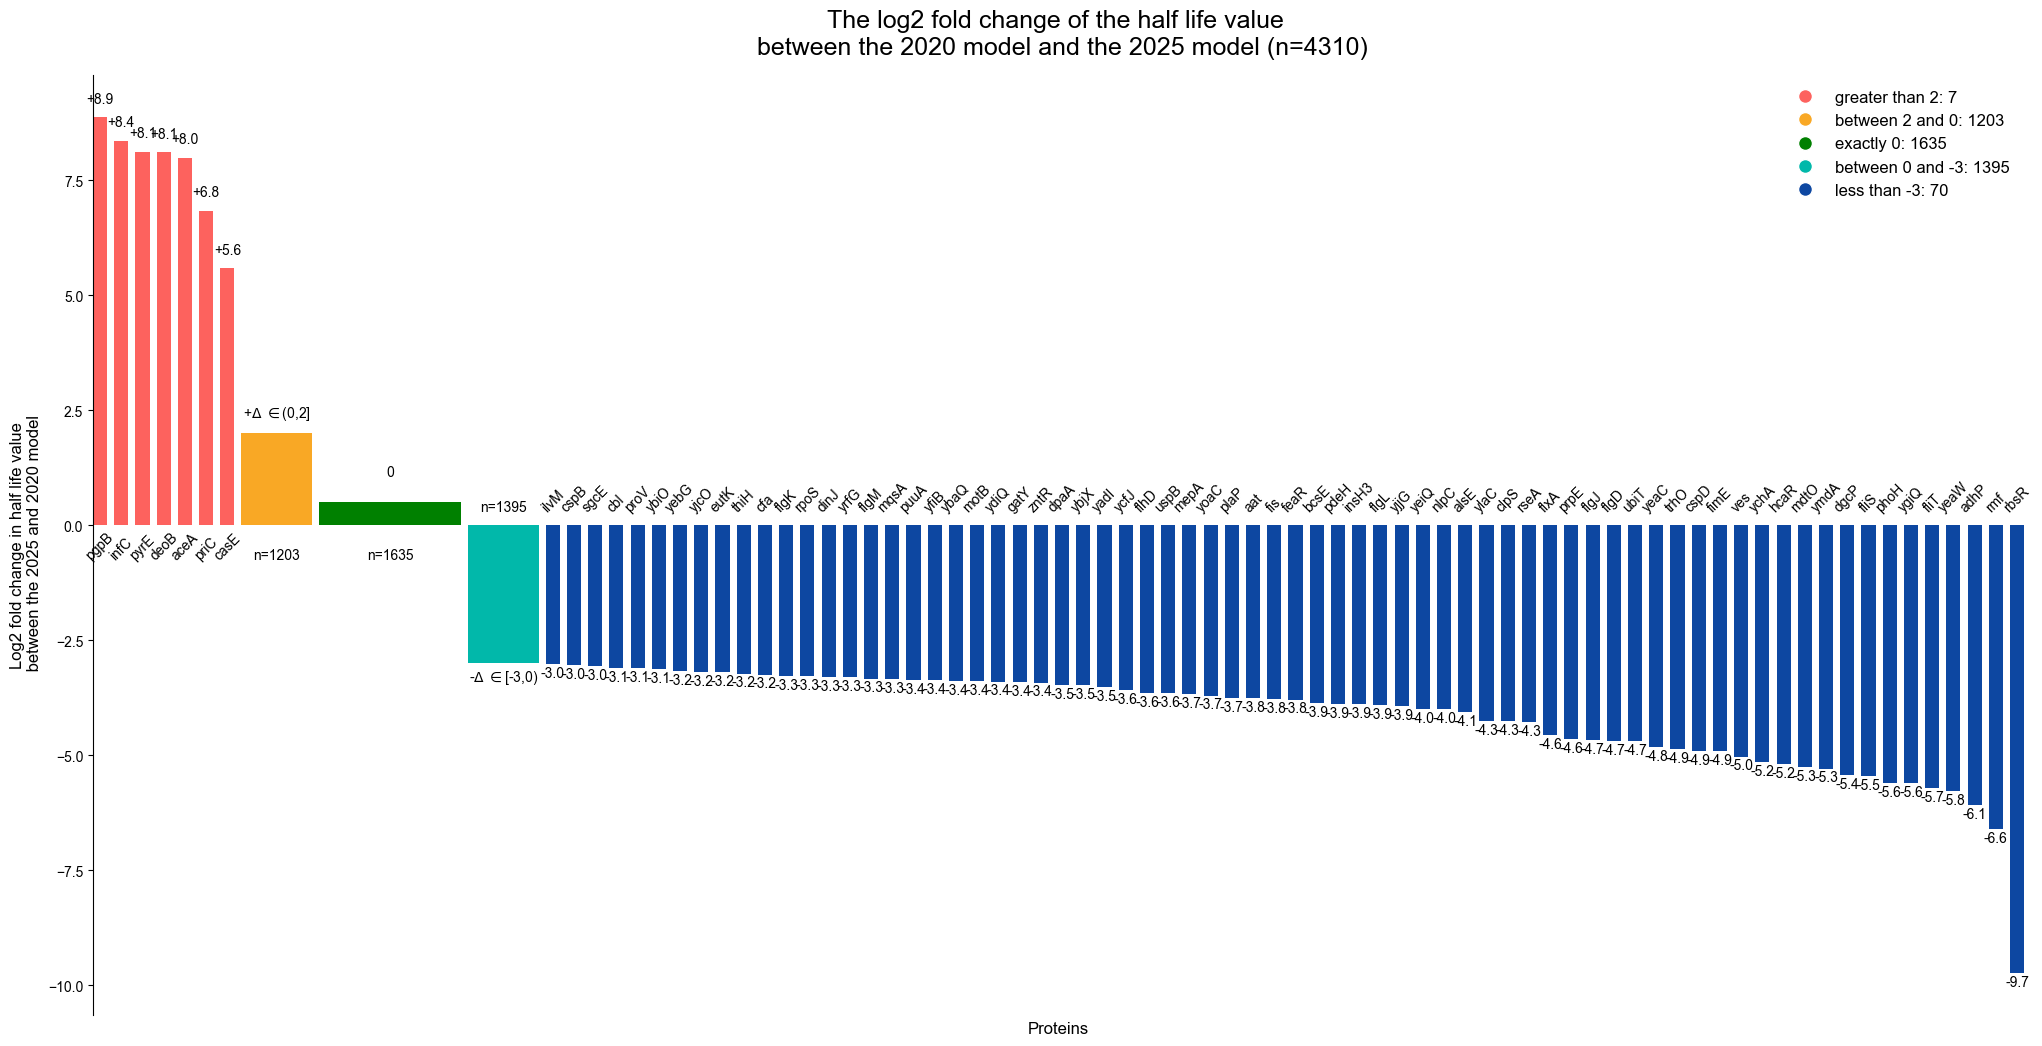

In [136]:
# define the data to use: 
df = combined_df.copy()

# define column to plot: 
column = 'HL_log2_fold_change'

# define bounds for changes
upper = 2
middle = 0
lower = -3

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_HL_values_with_all_proteins_[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'The log2 fold change of the half life value \n between the 2020 model and the 2025 model (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in half life value\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Generate the log2 fold change protein count bar plot

greater than 4: 23
between 4 and 0: 1619
exactly 0: 146
between 0 and -4: 2484
less than -4: 38


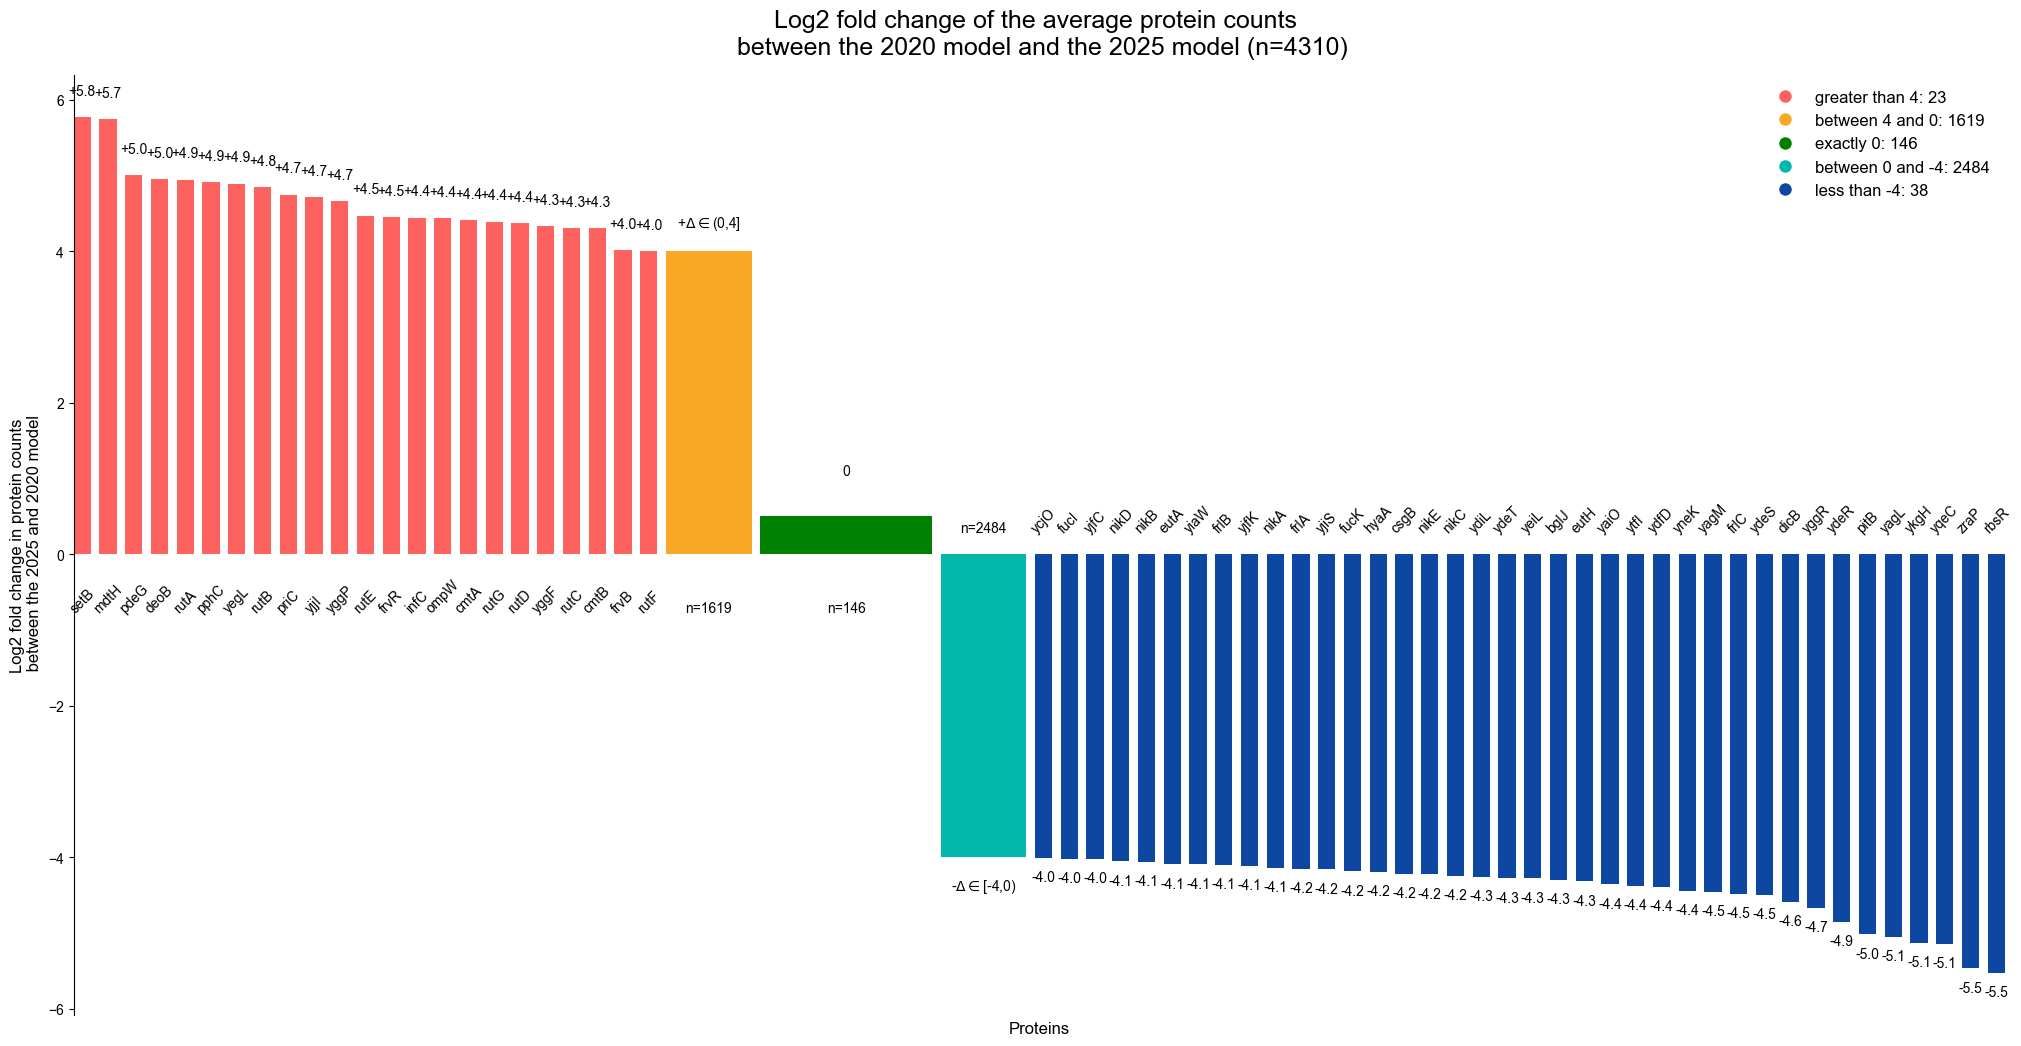

In [137]:
# define the data to use: 
df = combined_df.copy()

# define column to plot: 
column = 'PC_log2_fold_change'

# define bounds for changes
upper = 4
middle = 0
lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_protein_count_values_with_all_proteins_[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Log2 fold change of the average protein counts \n between the 2020 model and the 2025 model (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot the log2 fold change of the protein counts using only the proteins that had a change in half life from their original value

First prep the data: 

In [138]:
combined_df_of_proteins_with_new_HLs = combined_df.copy()

# remove the proteins that have a different half life value between new_half_life and original_half_life:
combined_df_of_proteins_with_new_HLs = combined_df_of_proteins_with_new_HLs[combined_df_of_proteins_with_new_HLs['HL_difference'] != 0] # should add up to 2675, as I believe that is how many were reassigned to Gupta et al. 2024 data! 

combined_df_of_proteins_with_new_HLs

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE2 Average Monomer Counts,HL_difference,HL_fold_change,HL_log2_fold_change,PC_difference,PC_fold_change,PC_log2_fold_change,counts_new_+10,counts_old_+10,log2_counts_10,Log10 Validation Data Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,501.707893,600.0,plsC,2.248895,2.229836,-98.292107,0.836180,-0.258115,-7.615718,0.957065,-0.063312,2.252271,2.270390,-0.011560,1.643453
1,1-PFK-MONOMER,766.256894,600.0,fruK,1.829031,1.882909,166.256894,1.277095,0.352866,8.909862,1.132081,0.178977,1.931293,1.883421,0.036211,1.755875
3,2-ISOPROPYLMALATESYN-MONOMER,276.924332,600.0,leuA,3.603593,3.570882,-323.075668,0.461541,-1.115471,-291.241331,0.927446,-0.108665,3.571930,3.604565,-0.013121,3.43329
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,493.397050,600.0,ubiE,2.619919,2.624710,-106.602950,0.822328,-0.282213,4.623403,1.011093,0.015915,2.633888,2.629197,0.002571,2.968483
5,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,796.038829,600.0,ubiB,1.791572,1.823803,196.038829,1.326731,0.407876,4.767411,1.077039,0.107071,1.878812,1.850542,0.021872,0.60206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,YRBF-MONOMER,823.833163,600.0,mlaF,2.469536,2.511339,223.833163,1.373055,0.457390,29.787130,1.101040,0.138867,2.523217,2.482596,0.023415,1.845098
4304,YTFQ-MONOMER,790.418789,600.0,ytfQ,1.641263,1.367367,190.418789,1.317365,0.397655,-20.478160,0.532235,-0.909865,1.509210,1.722459,-0.190676,2.0
4305,YTFR-MONOMER,654.149344,600.0,ytfR,1.591232,1.312354,54.149344,1.090249,0.124658,-18.486678,0.526165,-0.926412,1.470239,1.681377,-0.193592,0.0
4307,ZNUA-MONOMER,638.129701,600.0,znuA,2.792515,2.899656,38.129701,1.063550,0.088887,173.522890,1.279796,0.355914,2.904553,2.798773,0.053522,2.638489


Generate the log2 fold change protein count bar plot:

greater than 3: 14
between 3 and 0: 977
exactly 0: 3
between 0 and -3: 1658
less than -3: 23


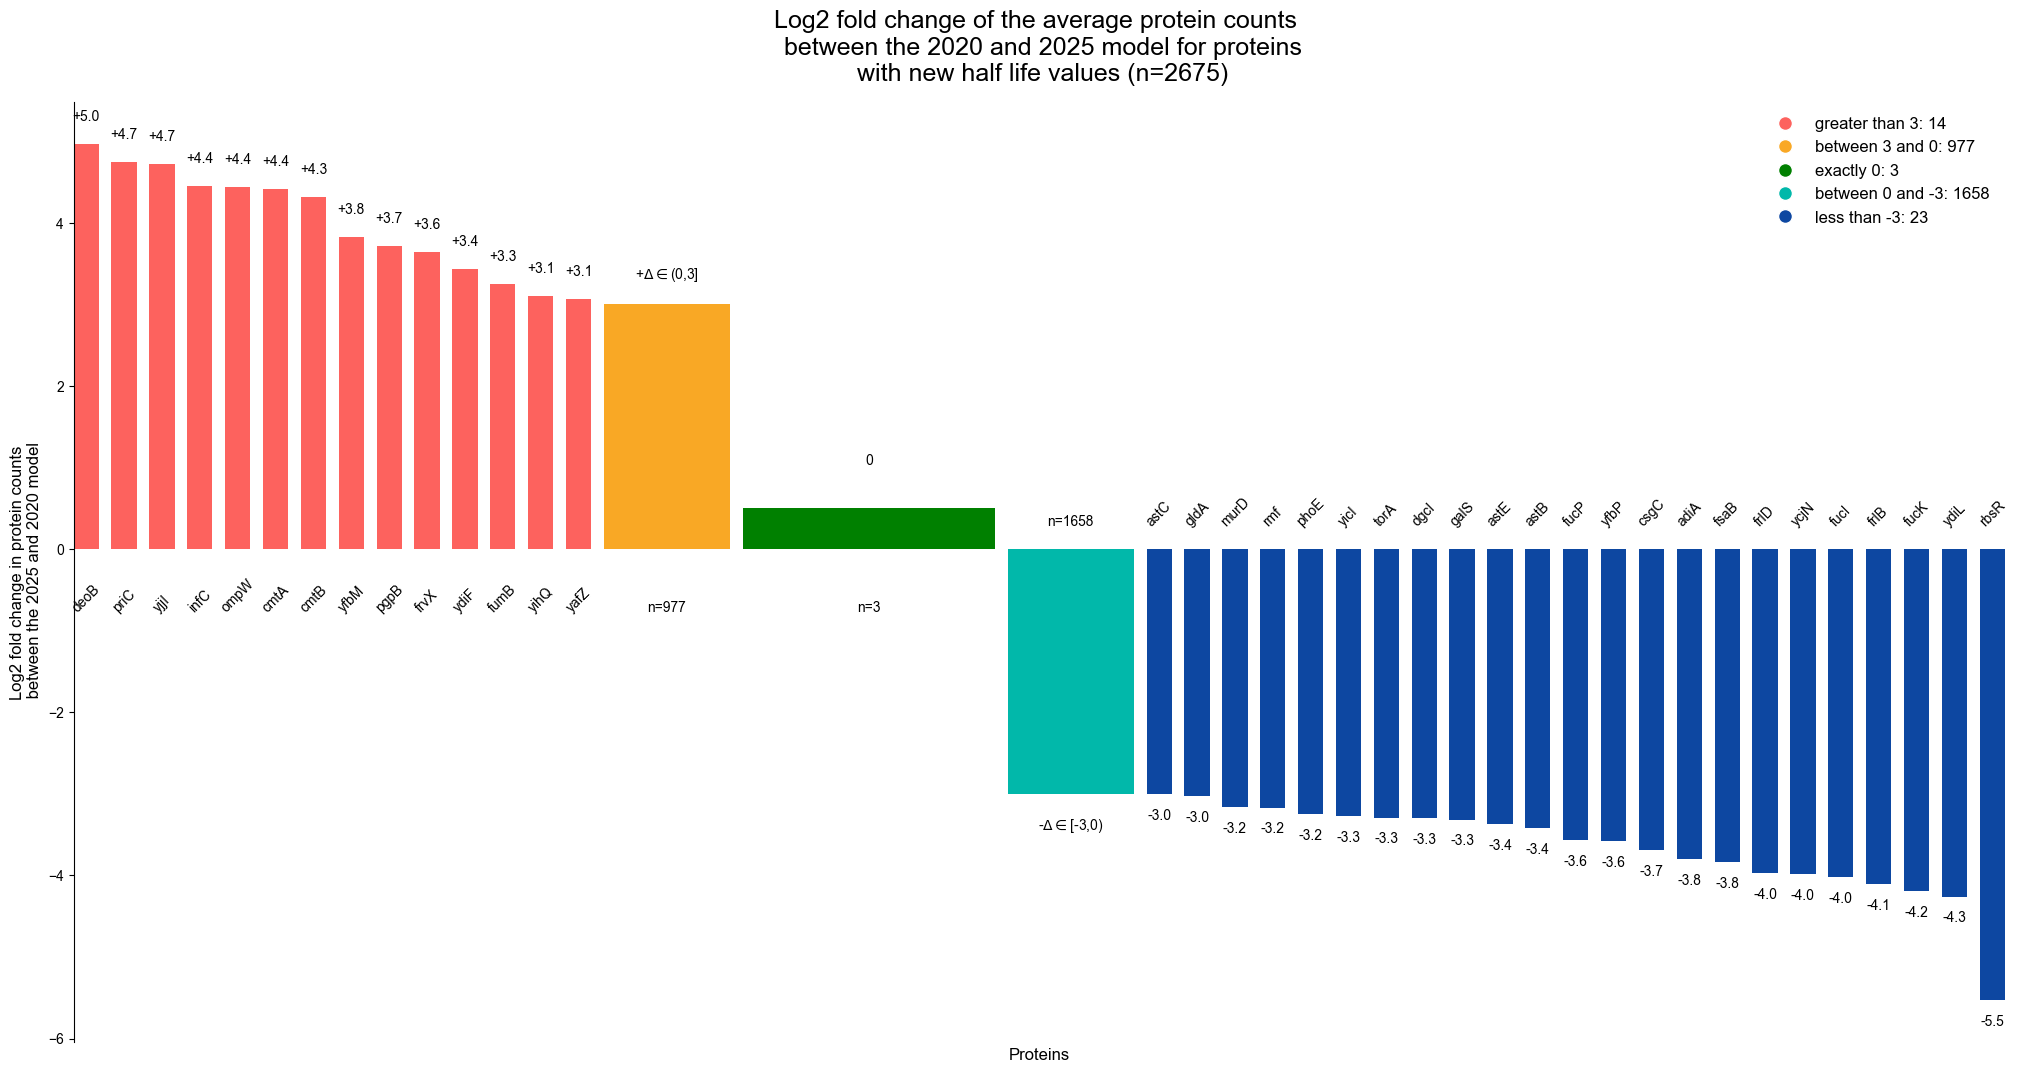

In [139]:
# define the dataframe to plot: 
df = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot: 
column = 'PC_log2_fold_change'

# define bounds for changes
upper = 3
middle = 0
lower = -3

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_protein_count_values_for_proteins_with_new_HL_values_bounds[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Log2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins\n with new half life values (n={df.shape[0]})'


# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   



# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot the log2 fold change of the protein counts using only the proteins that had no change in half life from their original value
Prep the data: 

In [140]:
combined_df_of_proteins_with_same_HLs = combined_df.copy()

# remove the proteins that have a different half life value between new_half_life and original_half_life:
combined_df_of_proteins_with_same_HLs = combined_df_of_proteins_with_same_HLs[combined_df_of_proteins_with_same_HLs['HL_difference'] == 0] # should add up to 2675, as I believe that is how many were reassigned to Gupta et al. 2024 data! 

combined_df_of_proteins_with_same_HLs


,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE2 Average Monomer Counts,HL_difference,HL_fold_change,HL_log2_fold_change,PC_difference,PC_fold_change,PC_log2_fold_change,counts_new_+10,counts_old_+10,log2_counts_10,Log10 Validation Data Average Monomer Counts
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,600.0,600.0,panE,2.155309,2.314904,0.0,1.0,0.0,63.501471,1.444094,0.530165,2.333432,2.181818,0.096923,1.414973
19,ABGT-MONOMER,600.0,600.0,abgT,0.496491,1.069420,0.0,1.0,0.0,8.596480,3.740502,1.903232,1.316669,1.084105,0.280388,None
30,ACPSUB-MONOMER,600.0,600.0,citD,0.000000,0.223900,0.0,1.0,0.0,0.674555,1.674555,0.743778,1.028350,1.000000,0.040331,None
33,ACRF-MONOMER,600.0,600.0,acrF,0.000000,0.000000,0.0,1.0,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,None
51,AGAC-MONOMER,600.0,600.0,agaC,0.045585,0.927470,0.0,1.0,0.0,7.351263,7.618762,2.929557,1.242092,1.004780,0.305893,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4299,YPHE-MONOMER,600.0,600.0,yphE,1.128710,1.115076,0.0,1.0,0.0,-0.415680,0.969094,-0.045292,1.343092,1.351209,-0.008693,None
4301,YRBE-MONOMER,600.0,600.0,mlaE,2.291749,2.314815,0.0,1.0,0.0,10.678950,1.054548,0.076625,2.333347,2.311269,0.013716,None
4303,YRBG-MONOMER,600.0,600.0,yrbG,1.438401,1.461090,0.0,1.0,0.0,1.471708,1.053632,0.075371,1.578786,1.561591,0.015799,None
4306,YTFT-MONOMER,600.0,600.0,ytfT,1.569764,1.268911,0.0,1.0,0.0,-18.559052,0.500205,-0.999410,1.440504,1.664015,-0.208095,None


Generate the log2 fold change protein count bar plot:

greater than 4: 16
between 4 and 0: 635
exactly 0: 143
between 0 and -4: 808
less than -4: 33


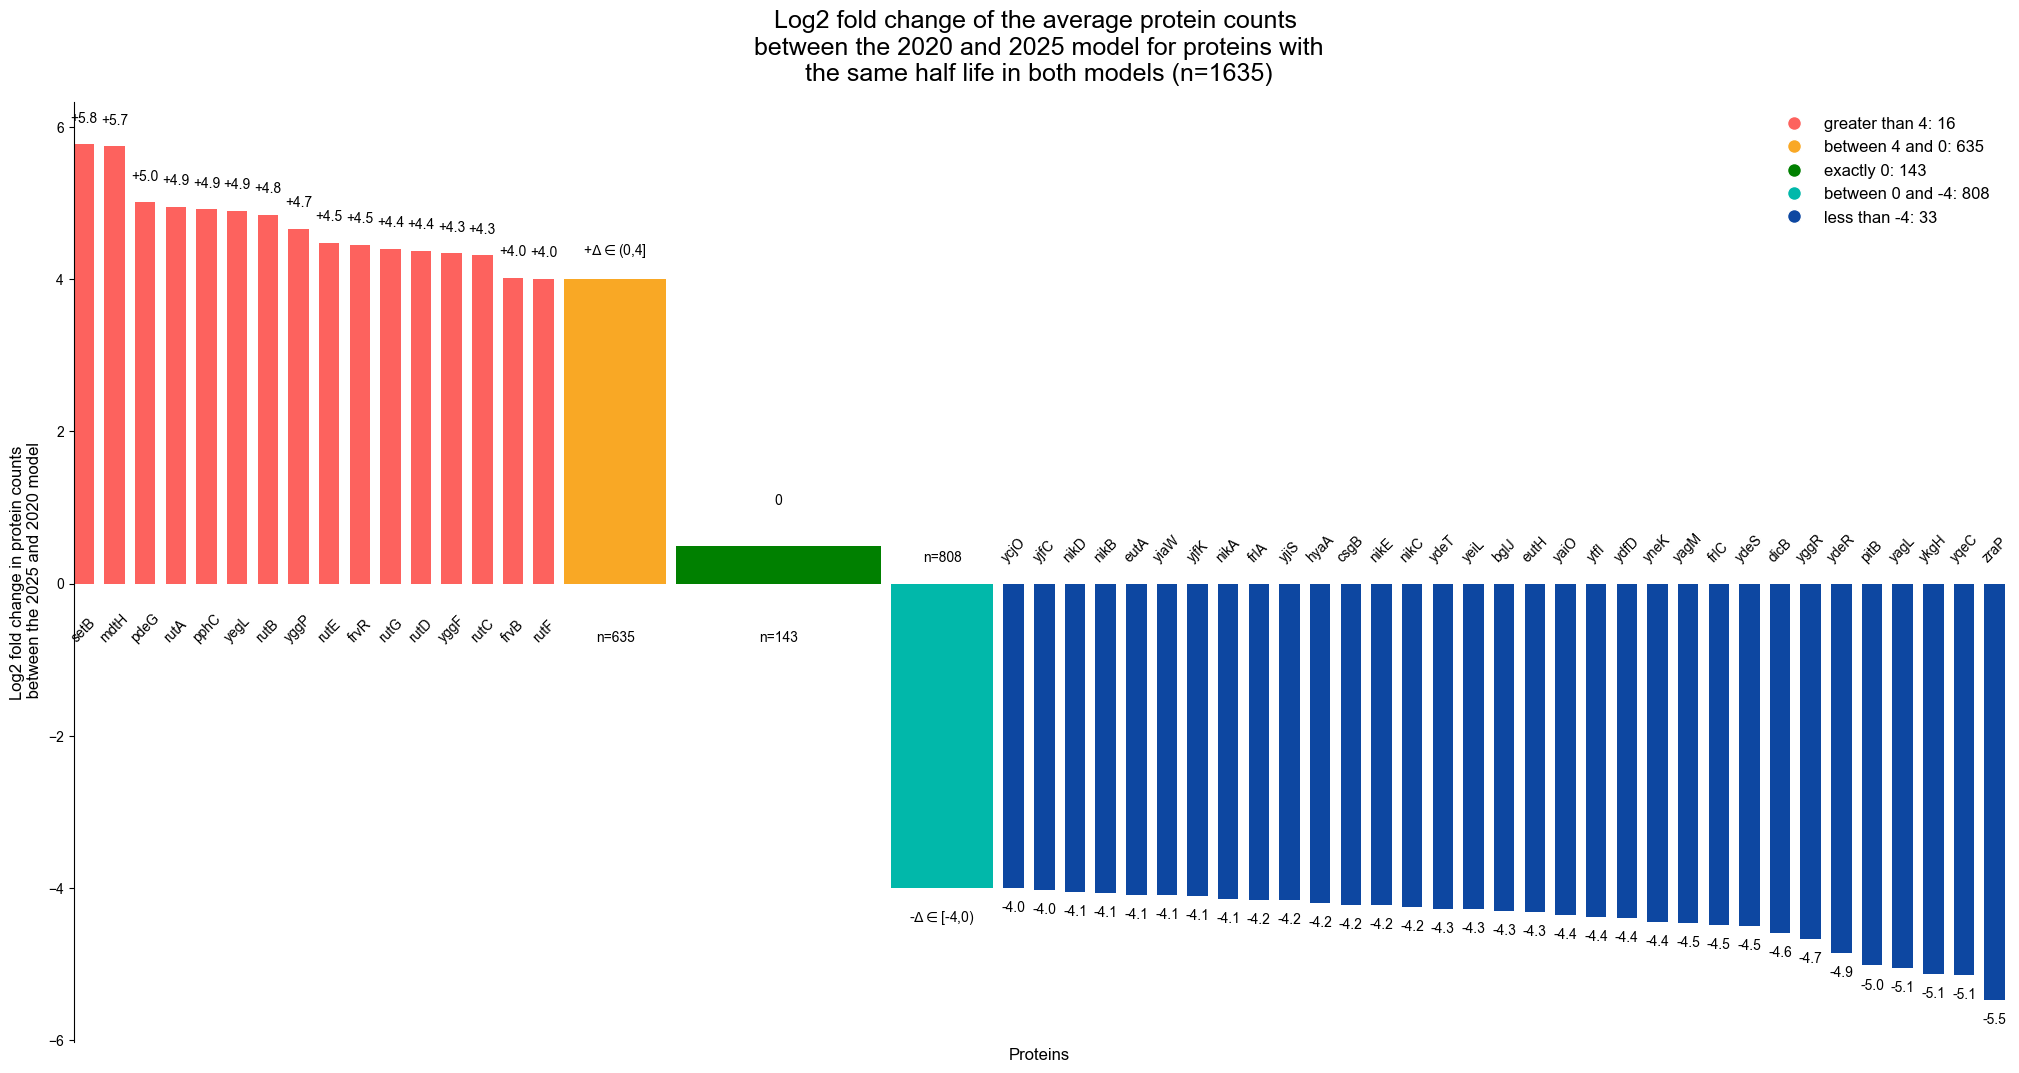

In [141]:
# define the data to use: 
df = combined_df_of_proteins_with_same_HLs.copy()

# define column to plot: 
column = 'PC_log2_fold_change'

# define bounds for changes
upper = 4
middle = 0
lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_protein_count_values_for_proteins_with_no_change_in_HL_bounds[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Log2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   



# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Histogram of protein count data

Histogram of all data: 

PC_log2_fold_change
count    1635.000000
mean       -0.181247
std         1.497057
min        -5.464947
25%        -0.732473
50%        -0.024856
75%         0.358817
max         5.768612
Name: PC_log2_fold_change, dtype: float64


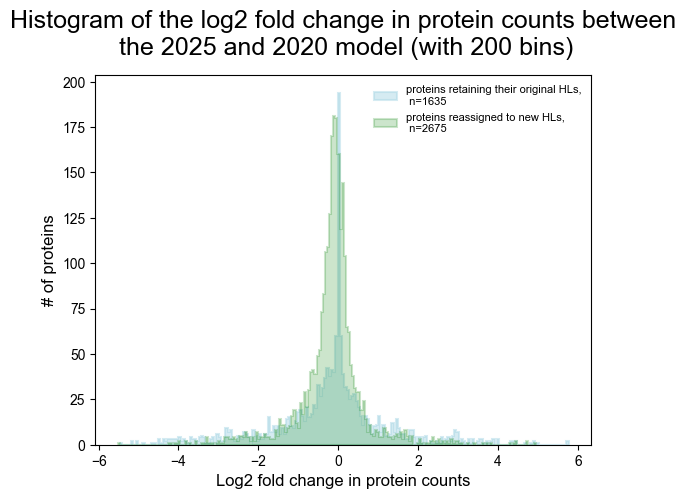

In [142]:
# make a histogram of the log2 fold change for protein counts: 

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'PC_log2_fold_change'
bins = 200

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_log2_fold_change_in_protein_count_values_bins[{bins}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Histogram of the log2 fold change in protein counts between\n the 2025 and 2020 model (with {bins} bins)' 

plt.hist(df1[column], histtype='stepfilled',bins=bins, color='lightblue', alpha=0.5, label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='lightblue', linewidth=1.5)
plt.hist(df2[column], bins=bins,histtype='stepfilled',  color='green', alpha=0.2, label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='green', linewidth=1.5) 

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Log2 fold change in protein counts', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)


# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

print(column)
print(df1[column].describe())

Same as above, but with bounds to see closer. 
NOTE: the plot will look different, because I am still using 100 bins but on a plot with a smaller x axis range, so there will be more split up of the values.

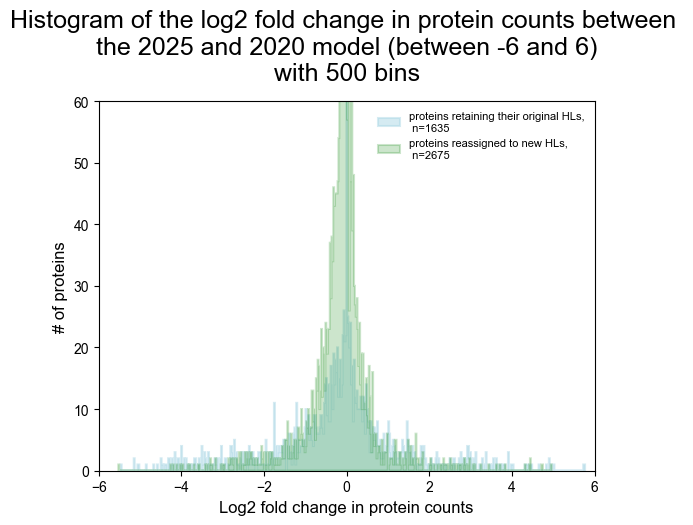

In [143]:
# make a histogram of the log2 fold change for protein counts: 

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'PC_log2_fold_change'

# define bounds for changes
upper = 6
lower = -6
bins = 500

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_log2_fold_change_in_protein_count_values_xbounds[{lower},{upper}]_bins[{bins}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Histogram of the log2 fold change in protein counts between \nthe 2025 and 2020 model (between {lower} and {upper})\nwith {bins} bins'

# take out the values that are above the upper bound:
df1 = df1[df1[column] < upper]
df2 = df2[df2[column] < upper]
# take out the values that are below the lower bound:
df1 = df1[df1[column] > lower]
df2 = df2[df2[column] > lower]

# make the histogram:
plt.hist(df1[column], histtype='stepfilled', bins=bins, color='lightblue', alpha=0.5,
         label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='lightblue', linewidth=1.5)
plt.hist(df2[column], bins=bins, histtype='stepfilled', color='green', alpha=0.2,
         label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='green', linewidth=1.5)

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Log2 fold change in protein counts', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.xlim(lower, upper)
plt.ylim(0, 60)
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


same as above but using seaborn:

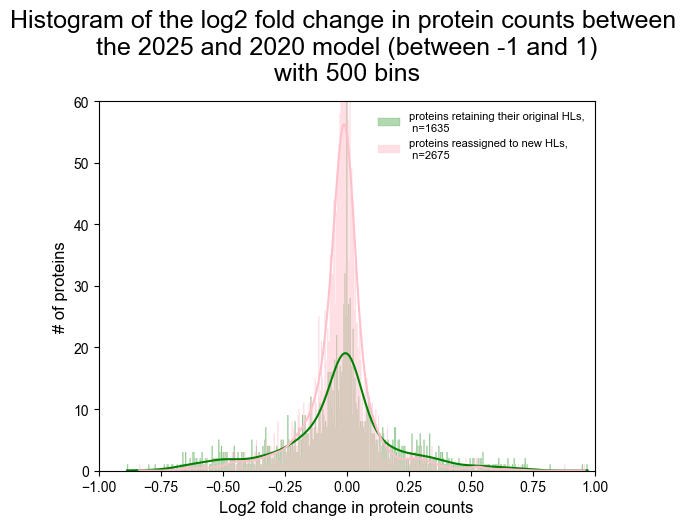

In [144]:
# make a histogram of the log2 fold change for protein counts: 
import seaborn as sns

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'log2_counts_10'
#column = 'PC_log2_fold_change'

# define bounds for changes
upper = 1
lower = -1
bins = 500

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_log2_fold_change_in_protein_count_values_using_sns_xbounds[{lower},{upper}]_bins[{bins}]_column[{column}]__{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Histogram of the log2 fold change in protein counts between \nthe 2025 and 2020 model (between {lower} and {upper})\nwith {bins} bins'

# take out the values that are above the upper bound:
df1 = df1[df1[column] < upper]
df2 = df2[df2[column] < upper]
# take out the values that are below the lower bound:
df1 = df1[df1[column] > lower]
df2 = df2[df2[column] > lower]

# make the histogram:
sns.histplot(df1[column],  bins=bins, color='green', alpha=0.3, kde=True, element='step',
         label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='green', linewidth=.1)
sns.histplot(df2[column], bins=bins,  color='pink', alpha=0.5, kde=True, element='step',
         label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='pink', linewidth=.1)

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Log2 fold change in protein counts', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.xlim(lower, upper)
plt.ylim(0, 60)
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Histogram of half life data

HL_log2_fold_change
count    2675.000000
mean       -0.354991
std         1.031811
min        -9.725345
25%        -0.597319
50%        -0.048343
75%         0.189010
max         8.870018
Name: HL_log2_fold_change, dtype: float64


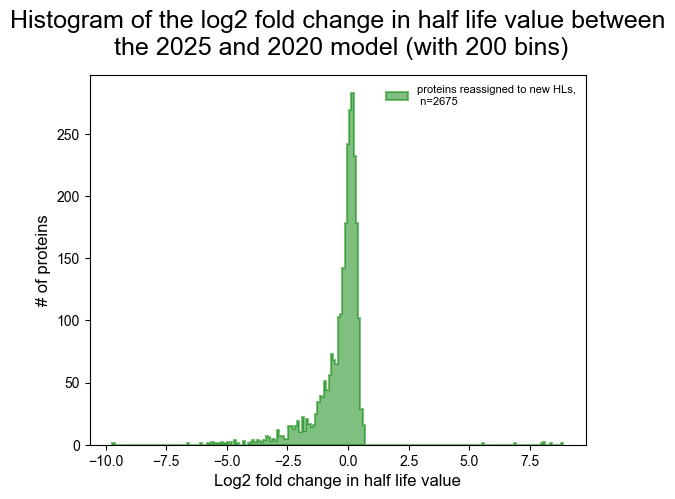

In [145]:
# make a histogram of the log2 fold change for protein counts: 

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'HL_log2_fold_change'
bins = 200

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_log2_fold_change_in_half_life_values_bins[{bins}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Histogram of the log2 fold change in half life value between\n the 2025 and 2020 model (with {bins} bins)' 

#plt.hist(df1[column], histtype='stepfilled',bins=bins, color='lightblue', alpha=0.5, label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='lightblue', linewidth=1.5)
plt.hist(df2[column], bins=bins,histtype='stepfilled',  color='green', alpha=0.5, label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='green', linewidth=1.5) 

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Log2 fold change in half life value', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)


# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

print(column)
print(df2[column].describe())

histogram of the new half lives only, but colored by if their difference is positive or negative:

PC_log2_fold_change
count    2675.000000
mean       -0.154274
std         0.838199
min        -5.523323
25%        -0.383633
50%        -0.102570
75%         0.126366
max         4.959511
Name: PC_log2_fold_change, dtype: float64


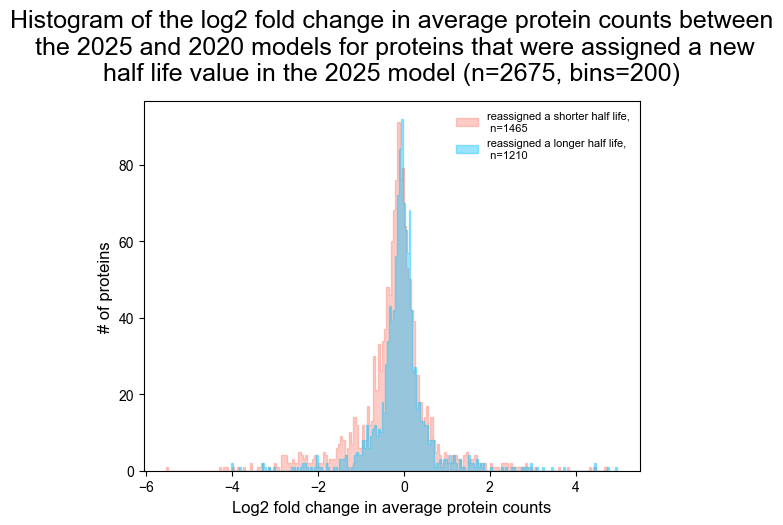

In [146]:
# make a histogram of the log2 fold change for protein counts: 

# define the data to use:
df2 = combined_df_of_proteins_with_new_HLs.copy()
# remove the proteins that have a different half life value between new_half_life and original_half_life:
df2_lower = df2[df2['HL_difference'] < 0]
df2_upper = df2[df2['HL_difference'] > 0]

# define column to plot:
column = 'PC_log2_fold_change'
bins = 200

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_log2_fold_change_in_protein_counts_for_only_proteins_with_new_HLs_bins[{bins}]__{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Histogram of the log2 fold change in average protein counts between\n the 2025 and 2020 models for proteins that were assigned a new\nhalf life value in the 2025 model (n={df2.shape[0]}, bins={bins})' 

plt.hist(df2_lower[column], histtype='stepfilled',bins=bins, color='salmon', alpha=0.4, label=f'reassigned a shorter half life,\n n={df2_lower.shape[0]}', edgecolor='salmon', linewidth=1)
plt.hist(df2_upper[column], bins=bins,histtype='stepfilled',  color='deepskyblue', alpha=0.4, label=f'reassigned a longer half life,\n n={df2_upper.shape[0]}', edgecolor='deepskyblue', linewidth=1) 

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Log2 fold change in average protein counts', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)


# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

print(column)
print(df2[column].describe())

# Matrix!


HL_log2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_log2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_log2_fold_change
count    4310.000000
mean       -0.164506
std         1.134034
min        -5.523323
25%        -0.463020
50%        -0.086052
75%         0.168907
max         5.768612
Name: PC_log2_fold_change, dtype: float64
greater than 4: 23
between 4 and 0: 1619
exactly 0: 146
between 0 and -4: 2484
less than -4: 38
HL_log2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_log2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_log2_fold_change
co

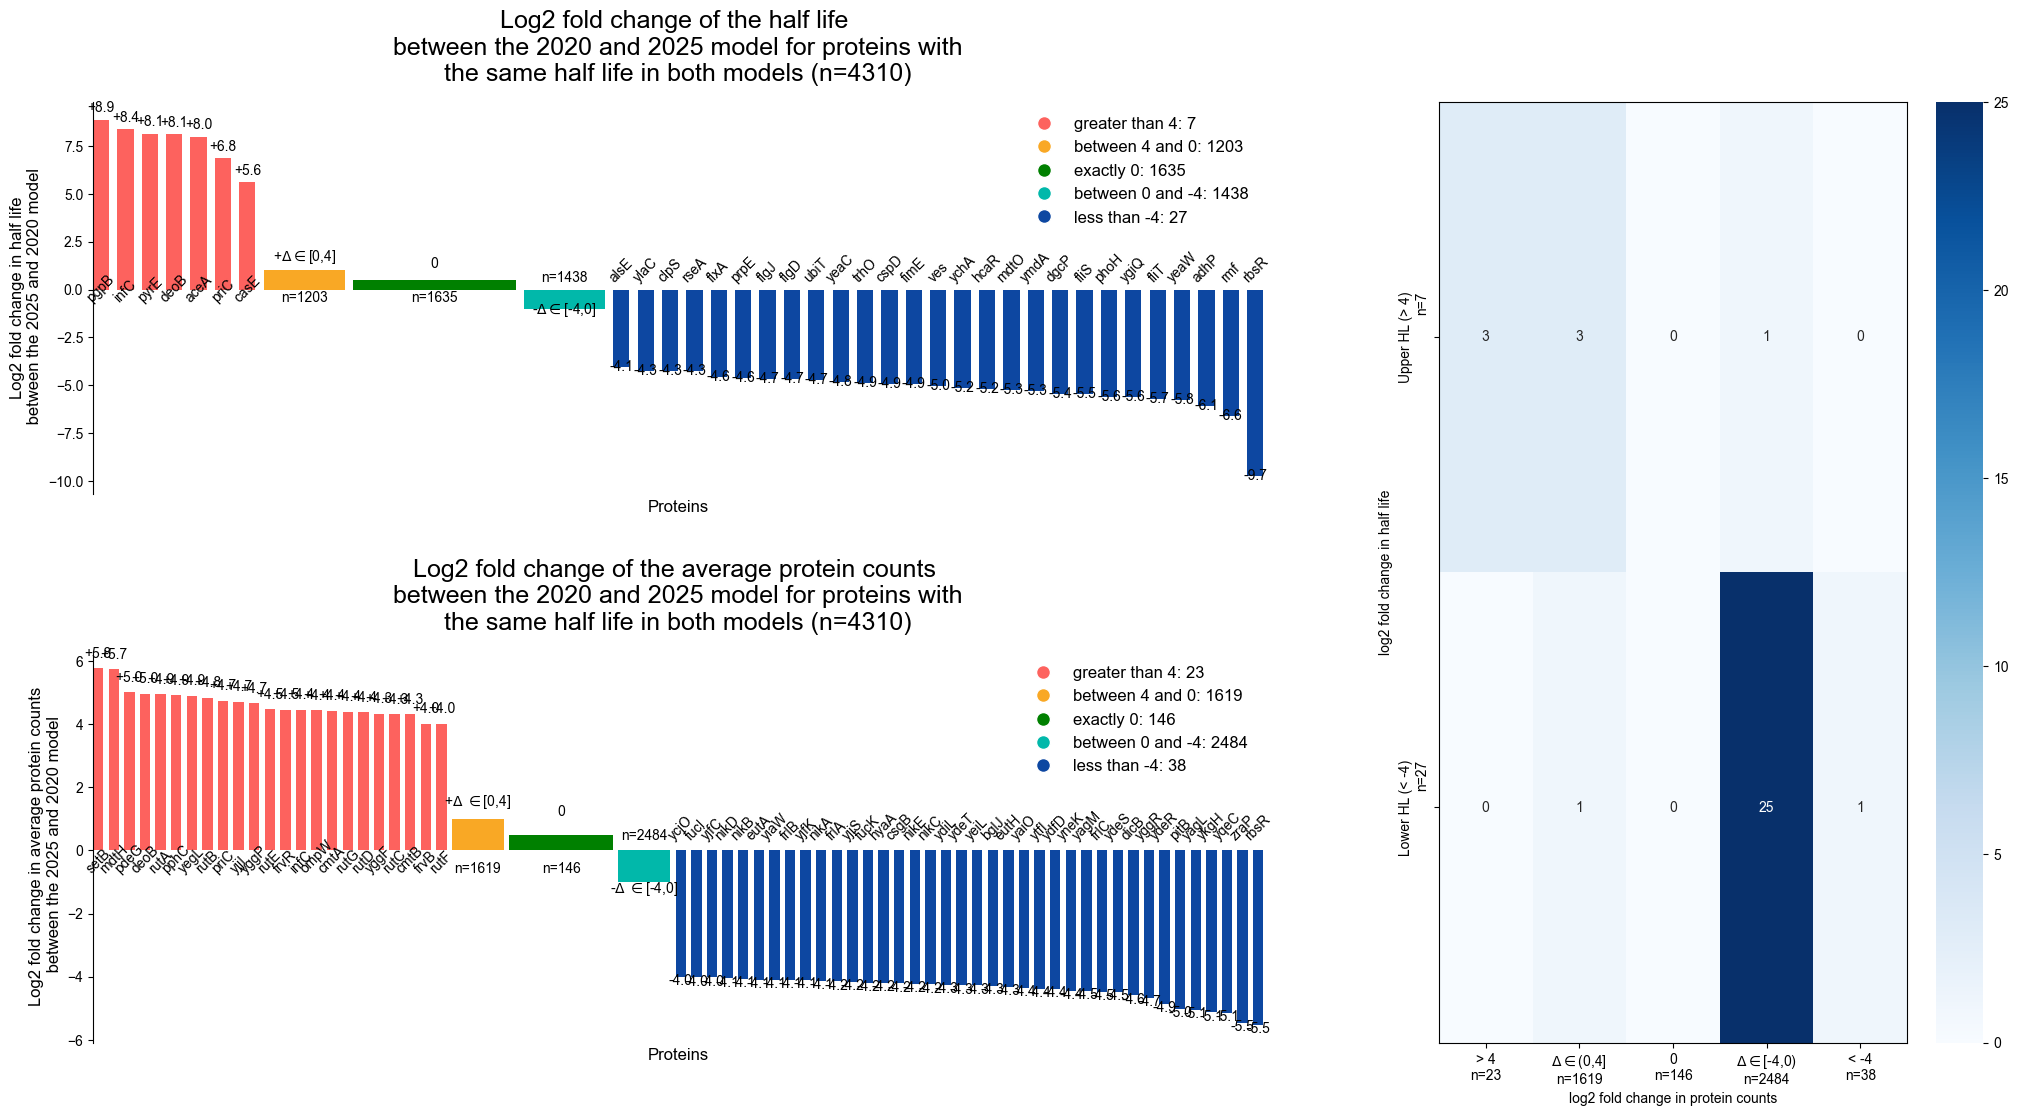

In [147]:
# time to make subplots! 

# define the data to use: 
df = combined_df.copy()

# define columns to plot: 
column0 = 'HL_log2_fold_change'
column1 = 'PC_log2_fold_change'

# define the title of the plot:
title0 = f'Log2 fold change of the half life \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'
title1 = f'Log2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'

# define bounds for changes in half lives:
HL_upper = 4
HL_middle = 0
HL_lower = -4

# define bounds for changes in protein counts:
PC_upper = 4
PC_middle = 0
PC_lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_HL_and_PC_values_for_all_proteins__HL_bounds[{HL_lower},{HL_middle},{HL_upper}]__PC_bounds[{PC_lower},{PC_middle},{PC_upper}]__with_matrix_{current_sequence}_{CLNE_sequence}.png"


def obtain_data(df, column, upper, middle, lower):
    print(column)
    print(df[column].describe())
    # find all of the half lives that are greater than 800:
    CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
    CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
    CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
    CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
    words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
    print(words_u)
    
    # find all the half lives between 800 and 0: 
    CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
    CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
    CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
    CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
    words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
    print(words_u2m)
    
    CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
    CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
    CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
    CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
    words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
    print(words_m)
    
    # find all half lives between 600 and 200: 
    CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
    CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
    CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
    CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
    words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
    print(words_m2l)
    
    # find all the half lives between 200 and 0:
    CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
    CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
    CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
    CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
    words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
    print(words_l)

    return(CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l)



def clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower):
    # make a new data frame that is more simple
    # concatenate the data frames together:
    CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
    data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]
    
    # add a new rows to the data: 
    new_rows = [
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
            column: upper,
            'sort_color': 'orange',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
            column: middle + 0.5,
            'sort_color': 'green',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
            column: lower,
            'sort_color': 'lightblue',
            'column_width': 4
        }
    ]
    
    # convert new rows to a DataFrame:
    new_rows_df = pd.DataFrame(new_rows)
    data = pd.concat([data, new_rows_df], ignore_index=True)
    
    # sort the data
    data = data.sort_values(by=[column], ascending=False)
    data.set_index('common_name', inplace=True)

    # create a color dictionary for the colors:
    color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}
    
    # create a size dictionary for the sizes:
    size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}
    
    upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
    lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])
    
    first_ticks = np.ones(upper_len) * size_dict['red']
    second_ticks = np.ones(1) * size_dict['orange']
    third_ticks = np.ones(1) * size_dict['green']
    fourth_ticks = np.ones(1) * size_dict['lightblue']
    fifth_ticks = np.ones(lower_len) * size_dict['blue']
    col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
    col_widths = np.concatenate(col_widths)
    col_widths
    
    # GET THE POSITIONS OF THE BARS
    # from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
    a = 0
    x_positions = []
    for i in range(len(col_widths)):
        if i == 0:
            a+=col_widths[i]
           
            x_positions.append(col_widths[i]/2)
            
        else:
            a += col_widths[i] + 0.05 # adding a gap 
           
            x_positions.append(a - col_widths[i]/2)
    
    x_positions = np.array(x_positions)
    
    return data, x_positions, col_widths, color_dict, size_dict



def make_subplot(row, col, df, column, variable, upper, middle, lower, title,):
    CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column, upper, middle, lower)
    
    data, x_positions, col_widths, color_dict, size_dict = clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower)
    
    # begin the plot:
    index = data.index
    
    # use the if row statement to tune the values added to the val varioable for each plot (as these may need to change depending on the bounds): 
    if column == 'HL_log2_fold_change':
        for i, val in enumerate(data[column]):
            axes[row, col].bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                axes[row, col].text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                axes[row, col].text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                axes[row, col].text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                axes[row, col].text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                axes[row, col].text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
                
    else:
        for i, val in enumerate(data[column]):
            axes[row, col].bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                axes[row, col].text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                axes[row, col].text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                axes[row, col].text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                axes[row, col].text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                axes[row, col].text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    
    # plot specifications:
    ax = axes[row, col]
    ax.set_title(title, fontsize=18, pad=15, )
    ax.set_ylabel(f'Log2 fold change in {variable}\n between the 2025 and 2020 model', fontsize=12, color="black", )
    ax.set_xlabel('Proteins', fontsize=12, color="black", )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.margins(x=0.0)


    ax.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)],
        loc='upper right', fontsize=12, frameon=False, markerscale=2)   



def find_inputs(input_df, u_output_df, u2m_output_df, m_output_df, m2l_output_df, l_output_df):
    #find where the common names in the input_df show up in the output df(s)
    in_u_output_df = input_df[input_df['common_name'].isin(u_output_df['common_name'])]
    in_u2m_output_df = input_df[input_df['common_name'].isin(u2m_output_df['common_name'])]
    in_m_output_df = input_df[input_df['common_name'].isin(m_output_df['common_name'])]
    in_m2l_output_df = input_df[input_df['common_name'].isin(m2l_output_df['common_name'])]
    in_l_output_df = input_df[input_df['common_name'].isin(l_output_df['common_name'])]
    
    # find the number of common names in each output df:
    u_count = in_u_output_df.shape[0]
    u2m_count = in_u2m_output_df.shape[0]
    m_count = in_m_output_df.shape[0]
    m2l_count = in_m2l_output_df.shape[0]
    l_count = in_l_output_df.shape[0]
    
    # create a dictionary of the counts:
    counts = {
        'u': u_count,
        'u2m': u2m_count,
        'm': m_count,
        'm2l': m2l_count,
        'l': l_count}
    
    return counts

# next, make a confusion matrix of the data:
def make_matrix(row, col, df, column0, column1, upper_HL, middle_HL, lower_HL, upper_PC, middle_PC, lower_PC):
    # make a confusion matrix of the data:
    HL_u, HL_u2m, HL_m, HL_m2l, HL_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column0, upper_HL, middle_HL, lower_HL)
    
    PC_u, PC_u2m, PC_m, PC_m2l, PC_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column1, upper_PC, middle_PC, lower_PC)
    
    # find the counts of the common names in each output df:
    counts1 = find_inputs(HL_u, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts2 = find_inputs(HL_l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    
    # make the matrix: 
    matrix_df = pd.DataFrame([
    [counts1['u'], counts1['u2m'], counts1['m'], counts1['m2l'], counts1['l']],
    [counts2['u'], counts2['u2m'], counts2['m'], counts2['m2l'], counts2['l']]  
    ], index=[f'Upper HL (> {upper_HL})\nn={HL_u.shape[0]}', f'Lower HL (< {lower_HL})\nn={HL_l.shape[0]}'],
   columns=[f'> {upper_PC}\nn={PC_u.shape[0]}', f'$\\Delta$$\\in$({middle_PC},{upper_PC}]\nn={PC_u2m.shape[0]}', f'{middle_PC}\nn={PC_m.shape[0]}', f'$\\Delta$$\\in$[{lower_PC},{middle_PC})\nn={PC_m2l.shape[0]}', f'< {lower_PC}\nn={PC_l.shape[0]}'])
     
    # make the heatmap take up the whole right side: 
    from matplotlib import gridspec
    fig.delaxes(axes[0, 1]) # delete the third axes
    fig.delaxes(axes[1, 1]) # delete the fourth axes 
    gridspecs = axes[0,0].get_gridspec() # get the gridspecs of the other axes
    axes_matrix = fig.add_subplot(gridspecs[:, 1]) # add a new axes to the gridspecs
    ax = axes_matrix
    
    # plot the matrix:
    sns.heatmap(matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    # plot specs: 
    ax.set_xlabel('log2 fold change in protein counts')
    ax.set_ylabel('log2 fold change in half life')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(20,10),  nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [2, 1]})
fig.tight_layout()

# plot the plots 
make_subplot(0, 0, df, column0, 'half life', HL_upper, HL_middle, HL_lower, title0)
make_subplot(1, 0, df, column1, 'average protein counts', PC_upper, PC_middle, PC_lower, title1)
make_matrix(0, 1, df, column0, column1, HL_upper, HL_middle, HL_lower, PC_upper, PC_middle, PC_lower)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot of all together!

HL_log2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_log2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_log2_fold_change
count    4310.000000
mean       -0.164506
std         1.134034
min        -5.523323
25%        -0.463020
50%        -0.086052
75%         0.168907
max         5.768612
Name: PC_log2_fold_change, dtype: float64
greater than 4.5: 11
between 4.5 and 0: 1631
exactly 0: 146
between 0 and -4: 2484
less than -4: 38
HL_log2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_log2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_log2_fold_chang

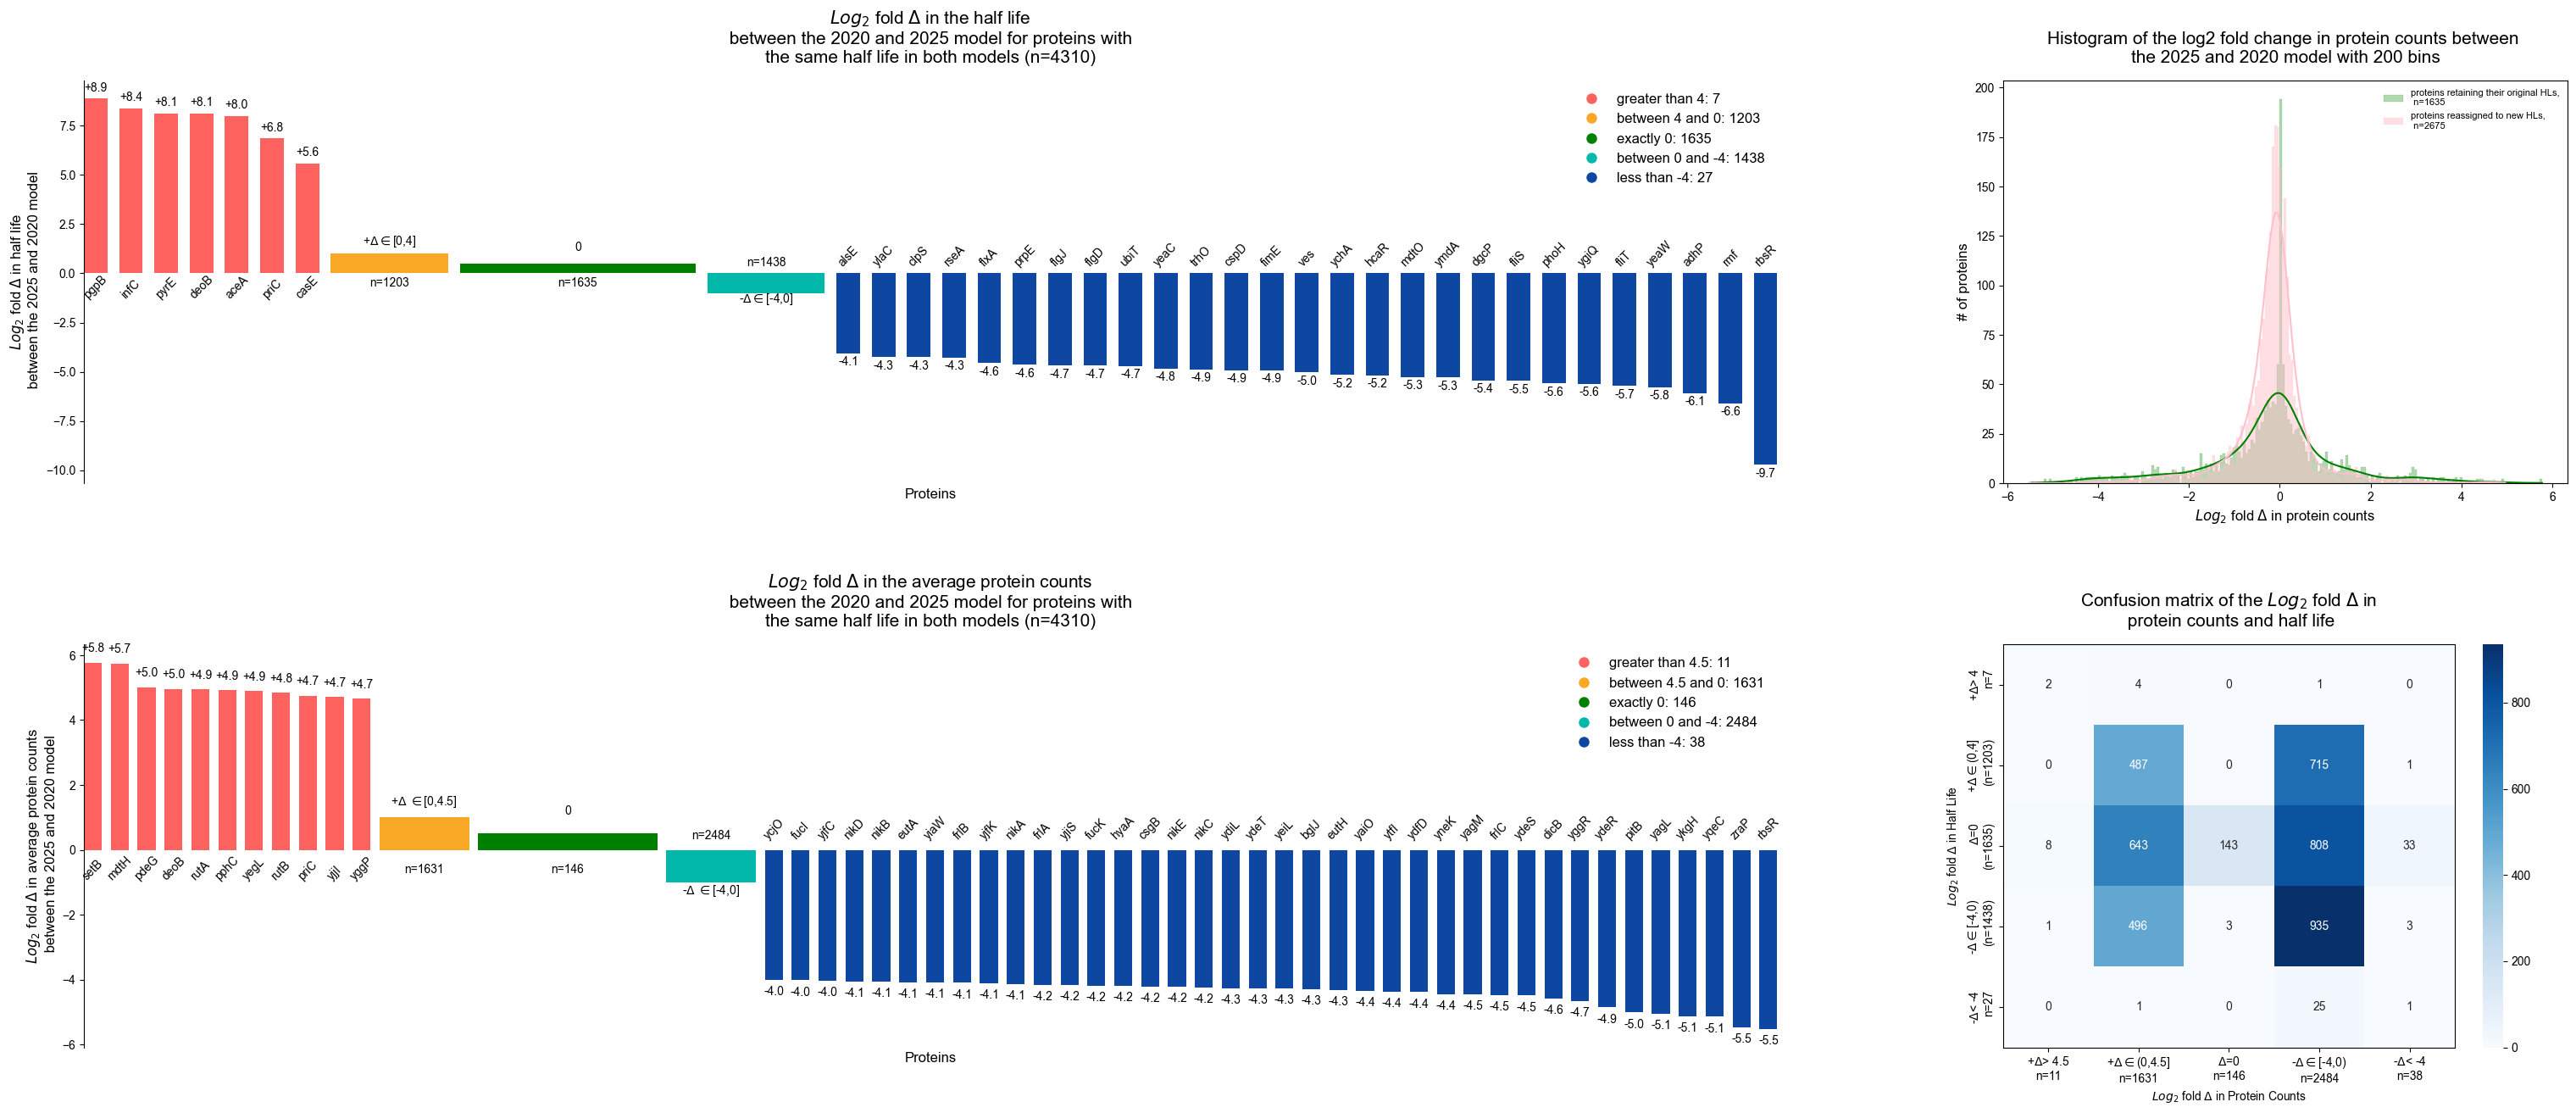

In [148]:
# time to make subplots! 

# define the data to use: 
df = combined_df.copy()

# define columns to plot: 
column0 = 'HL_log2_fold_change'
column1 = 'PC_log2_fold_change'

# define the title of the plot:
title0 = f'$Log_{2}$ fold $\\Delta$ in the half life \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'
title1 = f'$Log_{2}$ fold $\\Delta$ in the average protein counts \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'

# define bounds for changes in half lives:
HL_upper = 4
HL_middle = 0
HL_lower = -4

# define bounds for changes in protein counts:
PC_upper = 4.5
PC_middle = 0
PC_lower = -4

# define column to plot in the histogram:
column_histogram = 'PC_log2_fold_change'
# define bounds for changes in the histogram
upper_histogram = None
lower_histogram = None
bins_histogram = 200

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_HL_and_PC_values_for_all_proteins__HL_bounds[{HL_lower},{HL_middle},{HL_upper}]__PC_bounds[{PC_lower},{PC_middle},{PC_upper}]__histogram_xbounds[{upper_histogram},{lower_histogram}]_xbins[{bins_histogram}]__with_matrix_{current_sequence}_{CLNE_sequence}.png"


def obtain_data(df, column, upper, middle, lower):
    print(column)
    print(df[column].describe())
    # find all of the half lives that are greater than 800:
    CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
    CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
    CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
    CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
    words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
    print(words_u)
    
    # find all the half lives between 800 and 0: 
    CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
    CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
    CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
    CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
    words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
    print(words_u2m)
    
    CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
    CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
    CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
    CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
    words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
    print(words_m)
    
    # find all half lives between 600 and 200: 
    CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
    CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
    CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
    CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
    words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
    print(words_m2l)
    
    # find all the half lives between 200 and 0:
    CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
    CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
    CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
    CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
    words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
    print(words_l)

    return(CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l)



def clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower):
    # make a new data frame that is more simple
    # concatenate the data frames together:
    CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
    data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]
    
    # add a new rows to the data: 
    new_rows = [
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
            column: upper,
            'sort_color': 'orange',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
            column: middle + 0.5,
            'sort_color': 'green',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
            column: lower,
            'sort_color': 'lightblue',
            'column_width': 4
        }
    ]
    
    # convert new rows to a DataFrame:
    new_rows_df = pd.DataFrame(new_rows)
    data = pd.concat([data, new_rows_df], ignore_index=True)
    
    # sort the data
    data = data.sort_values(by=[column], ascending=False)
    data.set_index('common_name', inplace=True)

    # create a color dictionary for the colors:
    color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}
    
    # create a size dictionary for the sizes:
    size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}
    
    upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
    lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])
    
    first_ticks = np.ones(upper_len) * size_dict['red']
    second_ticks = np.ones(1) * size_dict['orange']
    third_ticks = np.ones(1) * size_dict['green']
    fourth_ticks = np.ones(1) * size_dict['lightblue']
    fifth_ticks = np.ones(lower_len) * size_dict['blue']
    col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
    col_widths = np.concatenate(col_widths)
    
    # GET THE POSITIONS OF THE BARS
    # from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
    a = 0
    x_positions = []
    for i in range(len(col_widths)):
        if i == 0:
            a+=col_widths[i]
           
            x_positions.append(col_widths[i]/2)
            
        else:
            a += col_widths[i] + 0.05 # adding a gap 
           
            x_positions.append(a - col_widths[i]/2)
    
    x_positions = np.array(x_positions)
    
    return data, x_positions, col_widths, color_dict, size_dict



def make_subplot(row, col, df, column, variable, upper, middle, lower, title,):
    CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column, upper, middle, lower)
    
    data, x_positions, col_widths, color_dict, size_dict = clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower)
    
    # begin the plot:
    index = data.index
    ax = axes[row, col]
    
    # use the if row statement to tune the values added to the val varioable for each plot (as these may need to change depending on the bounds): 
    if column == 'HL_log2_fold_change':
        for i, val in enumerate(data[column]):
            ax.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                ax.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 1.4, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                ax.text(x_positions[i], val - 0.75, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                ax.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                ax.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                ax.text(x_positions[i], val - .7, f"-$\\Delta$$\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
                
    else:
        for i, val in enumerate(data[column]):
            ax.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                ax.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 1, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                ax.text(x_positions[i], val - 0.55, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                ax.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                ax.text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                ax.text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    
    # plot specifications:
    ax.set_title(title, fontsize=15, pad=15, )
    ax.set_ylabel(f'$Log_{2}$ fold $\\Delta$ in {variable}\n between the 2025 and 2020 model', fontsize=12, color="black", )
    ax.set_xlabel('Proteins', fontsize=12, color="black", )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.margins(x=0.0)


    ax.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)],
        loc='upper right', fontsize=12, frameon=False, markerscale=2)   



def find_inputs(input_df, u_output_df, u2m_output_df, m_output_df, m2l_output_df, l_output_df):
    #find where the common names in the input_df show up in the output df(s)
    in_u_output_df = input_df[input_df['common_name'].isin(u_output_df['common_name'])]
    in_u2m_output_df = input_df[input_df['common_name'].isin(u2m_output_df['common_name'])]
    print(in_u2m_output_df)
    in_m_output_df = input_df[input_df['common_name'].isin(m_output_df['common_name'])]
    in_m2l_output_df = input_df[input_df['common_name'].isin(m2l_output_df['common_name'])]
    in_l_output_df = input_df[input_df['common_name'].isin(l_output_df['common_name'])]
    
    # find the number of common names in each output df:
    u_count = in_u_output_df.shape[0]
    u2m_count = in_u2m_output_df.shape[0]
    m_count = in_m_output_df.shape[0]
    m2l_count = in_m2l_output_df.shape[0]
    l_count = in_l_output_df.shape[0]
    
    
    # create a dictionary of the counts:
    counts = {
        'u': u_count,
        'u2m': u2m_count,
        'm': m_count,
        'm2l': m2l_count,
        'l': l_count}
    
    return counts

def make_histogram(row, col, df, column, bins, upper=None, lower=None):
    # make a histogram of the log2 fold change for protein counts: 
    ax = axes[row, col]
    import seaborn as sns
    
    # define the data to use:    
    combined_df_of_proteins_with_same_HLs = df[df['HL_difference'] == 0]
    combined_df_of_proteins_with_new_HLs = df[df['HL_difference'] != 0]
    df1 = combined_df_of_proteins_with_same_HLs.copy()
    df2 = combined_df_of_proteins_with_new_HLs.copy()
    
    # define the title of the plot:
    if upper == None and lower == None:
        title = f'Histogram of the log2 fold change in protein counts between \nthe 2025 and 2020 model with {bins} bins'
    else:
        # take out the values that are above the upper bound:
        df1 = df1[df1[column] < upper]
        df2 = df2[df2[column] < upper]
        # take out the values that are below the lower bound:
        df1 = df1[df1[column] > lower]
        df2 = df2[df2[column] > lower]
        # get the size of the data:
        num = df1.shape[0] + df2.shape[0]
        title = f'Histogram of the log2 fold change in protein counts between \nthe 2025 and 2020 model (between {lower} and {upper}, n={num})\nwith {bins} bins'
        
    
    # make the histogram:
    sns.histplot(df1[column],  bins=bins, color='green', alpha=0.3, kde=True, element='step',
             label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='green', linewidth=.1, ax=ax)
    sns.histplot(df2[column], bins=bins,  color='pink', alpha=0.5, kde=True, element='step',
             label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='pink', linewidth=.1, ax=ax)
    
    ax.set_title(title, fontsize=15, pad=15, )
    ax.set_xlabel(f'$Log_{2}$ fold $\\Delta$ in protein counts', fontsize=12, color="black", )
    ax.set_ylabel('# of proteins', fontsize=12, color="black", )
    ax.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)
    


# next, make a confusion matrix of the data:
def make_matrix(row, col, df, column0, column1, upper_HL, middle_HL, lower_HL, upper_PC, middle_PC, lower_PC):
    # make a confusion matrix of the data:
    HL_u, HL_u2m, HL_m, HL_m2l, HL_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column0, upper_HL, middle_HL, lower_HL)
    
    PC_u, PC_u2m, PC_m, PC_m2l, PC_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column1, upper_PC, middle_PC, lower_PC)
    
    # find the counts of the common names in each output df:
    counts1 = find_inputs(HL_u, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts2 = find_inputs(HL_u2m, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts3 = find_inputs(HL_m, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts4 = find_inputs(HL_m2l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts5 = find_inputs(HL_l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    
    # make the matrix: 
    matrix_df = pd.DataFrame([
    [counts1['u'], counts1['u2m'], counts1['m'], counts1['m2l'], counts1['l']],
    [counts2['u'], counts2['u2m'], counts2['m'], counts2['m2l'], counts2['l']],
    [counts3['u'], counts3['u2m'], counts3['m'], counts3['m2l'], counts3['l']],
    [counts4['u'], counts4['u2m'], counts4['m'], counts4['m2l'], counts4['l']],
    [counts5['u'], counts5['u2m'], counts5['m'], counts5['m2l'], counts5['l']]], 
    index=[f'+$\\Delta$> {upper_HL}\nn={HL_u.shape[0]}',f'+$\\Delta$$\\in$({middle_HL},{upper_HL}]\n(n={HL_u2m.shape[0]})', f'$\\Delta$={middle_HL}\n(n={HL_m.shape[0]})', f'-$\\Delta$$\\in$[{lower_HL},{middle_HL})\n(n={HL_m2l.shape[0]})', f'-$\\Delta$< {lower_HL}\nn={HL_l.shape[0]}'],
    columns=[f'+$\\Delta$> {upper_PC}\nn={PC_u.shape[0]}', f'+$\\Delta$$\\in$({middle_PC},{upper_PC}]\nn={PC_u2m.shape[0]}', f'$\\Delta$={middle_PC}\nn={PC_m.shape[0]}',f'-$\\Delta$$\\in$[{lower_PC},{middle_PC})\nn={PC_m2l.shape[0]}',  f'-$\\Delta$< {lower_PC}\nn={PC_l.shape[0]}'])
    
    # plot the matrix: 
    ax = axes[row, col]
    sns.heatmap(matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    # plot the confusion matrix:
    ax.set_title(f'Confusion matrix of the $Log_{2}$ fold $\\Delta$ in\n protein counts and half life', fontsize=15, pad=15, )
    ax.set_xlabel(f'$Log_{2}$ fold $\\Delta$ in Protein Counts')
    ax.set_ylabel(f'$Log_{2}$ fold $\\Delta$ in Half Life')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)


# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(30,12),  nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [3, 1]})
fig.tight_layout()

# plot the plots 
make_subplot(0, 0, df, column0, 'half life', HL_upper, HL_middle, HL_lower, title0)
make_subplot(1, 0, df, column1, 'average protein counts', PC_upper, PC_middle, PC_lower, title1)
make_histogram(0, 1, df, column1, bins_histogram, upper_histogram, lower_histogram)
make_matrix(1, 1, df, column0, column1, HL_upper, HL_middle, HL_lower, PC_upper, PC_middle, PC_lower)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# ok now it is time to get the validation data involved! 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HL_log2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_log2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27


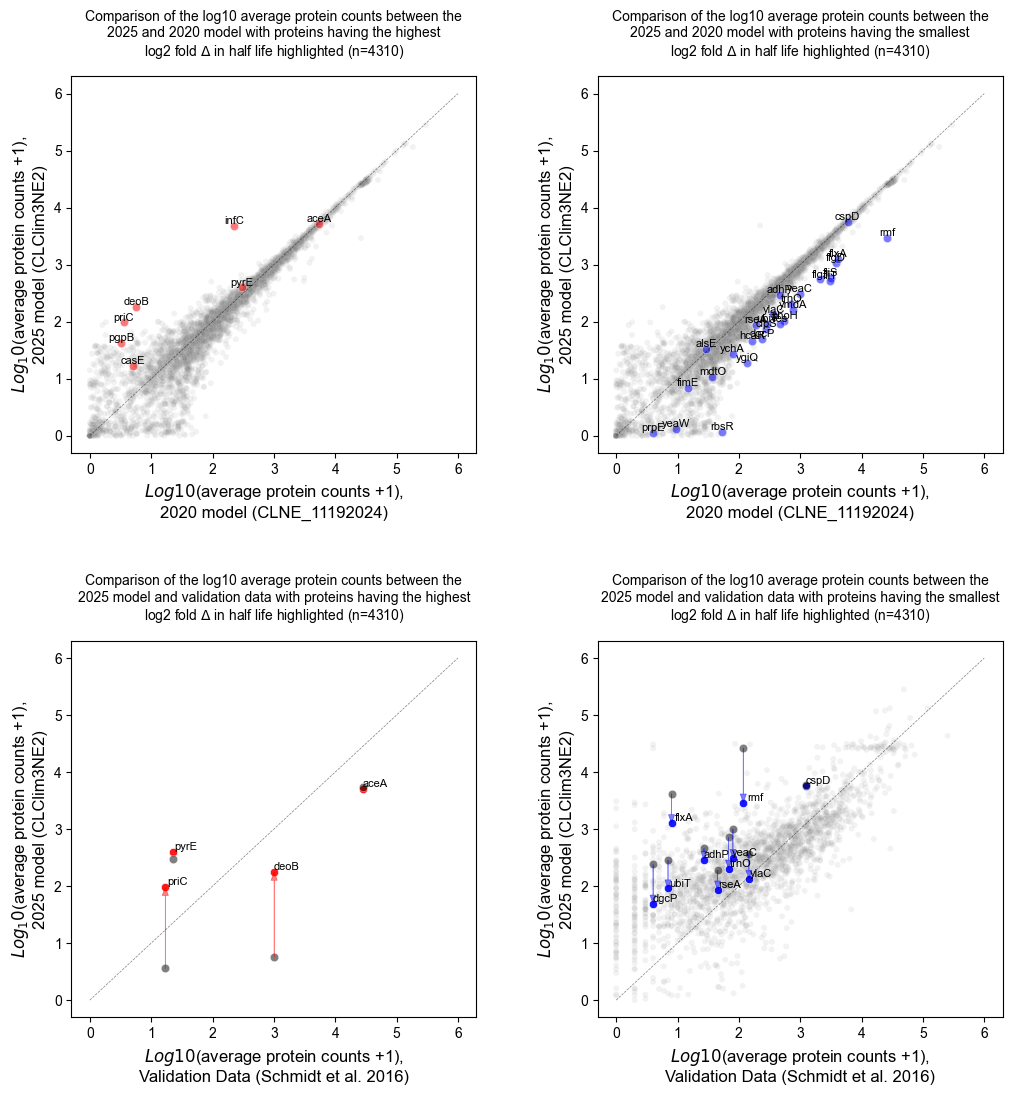

In [189]:
# ok so get the validation data; 

column = 'HL_log2_fold_change'
validaiton_column = 'Log10 Validation Data Average Monomer Counts'

CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column, HL_upper, HL_middle, HL_lower)


# ok now make a 2 by 2 plot

def make_counts_comparison_with_upper_HL_change_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df, x=whole_df[CLNE_new_name], y=whole_df[CLClimNE_new_name], color='grey', size=0.1, alpha=0.1, ax=ax)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df, x=interest_df[CLNE_new_name], y=interest_df[CLClimNE_new_name], color='red', alpha=0.5, ax=ax)
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df['common_name'].unique()):
        # get the index of the protein:
        index = interest_df[interest_df['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df[CLNE_new_name][index]
        y = interest_df[CLClimNE_new_name][index]
        # plot the common name:
        ax.text(x, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 and 2020 model with proteins having the highest\nlog2 fold $\\Delta$ in half life highlighted (n={whole_df.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\n2020 model ({CLNE_sequence})', fontsize=12, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=12, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)
    

    
def make_counts_comparison_with_lower_HL_change_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df, x=whole_df[CLNE_new_name], y=whole_df[CLClimNE_new_name], color='grey', size=1, alpha=0.1, ax=ax)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df, x=interest_df[CLNE_new_name], y=interest_df[CLClimNE_new_name], color='blue', alpha=0.5, ax=ax)
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)

    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df['common_name'].unique()):
        # get the index of the protein:
        index = interest_df[interest_df['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df[CLNE_new_name][index]
        y = interest_df[CLClimNE_new_name][index]
        # plot the common name:
        ax.text(x, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 and 2020 model with proteins having the smallest\nlog2 fold $\\Delta$ in half life highlighted (n={whole_df.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\n2020 model ({CLNE_sequence})', fontsize=12, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=12, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)
    
# now make a plot for the validation comparison: 
def make_counts_comparison_with_upper_HL_change_validation_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[y_col].notna()]
    interest_df_to_plot = interest_df[interest_df[x_col].notna()]

    
    # plot all of the proteins 
    #sns.scatterplot(data=whole_df, x=whole_df[x_col], y=whole_df[y_col], color='grey', alpha=0.1, ax=ax)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col], color='red', alpha=0.9, ax=ax)
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col2], color='black', alpha=0.5, ax=ax)
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df_to_plot['common_name'].unique()):
        # get the index of the protein:
        index = interest_df_to_plot[interest_df_to_plot['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df_to_plot[x_col][index]
        y = interest_df_to_plot[y_col][index]
        # plot the common name:
        ax.text(x+.2, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
        
        # also make a line between the two: 
        y2 = interest_df_to_plot[y_col2][index]
        difference = y - y2
        if difference > 0.2:
            dx = x-x
            dy = y - y2
            #ax.arrow([x, x], [y, y2], color='red', linewidth=.5, alpha=0.5)
            ax.arrow(x, y2, dx, dy, color='red', linewidth=.5, alpha=0.5, head_width=0.1, head_length=0.15, length_includes_head=True)
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 model and validation data with proteins having the highest\nlog2 fold $\\Delta$ in half life highlighted (n={whole_df_to_plot.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=12, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=12, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)


# now make a plot for the validation comparison: 
def make_counts_comparison_with_lower_HL_change_validation_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[y_col].notna()]
    interest_df_to_plot = interest_df[interest_df[x_col].notna()]

    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df, x=whole_df[x_col], y=whole_df[y_col], color='grey', size=.1, alpha=0.1, ax=ax)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col], color='blue', alpha=0.9, ax=ax)
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col2], color='black', alpha=0.5, ax=ax)
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df_to_plot['common_name'].unique()):
        # get the index of the protein:
        index = interest_df_to_plot[interest_df_to_plot['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df_to_plot[x_col][index]
        y = interest_df_to_plot[y_col][index]
        # plot the common name:
        ax.text(x+.2, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
        
        # also make a line between the two: 
        y2 = interest_df_to_plot[y_col2][index]
        difference = y - y2
        if difference < -0.2:
            dx = x-x
            dy = y - y2
            #ax.arrow([x, x], [y, y2], color='red', linewidth=.5, alpha=0.5)
            ax.arrow(x, y2, dx, dy, color='blue', linewidth=.5, alpha=0.5, head_width=0.1, head_length=0.15, length_includes_head=True)
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 model and validation data with proteins having the smallest\nlog2 fold $\\Delta$ in half life highlighted (n={whole_df_to_plot.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=12, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=12, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)


# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(10,10),  nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})
fig.tight_layout()

# plot the plots 
make_counts_comparison_with_upper_HL_change_data(0, 0, combined_df, CLClim3NE1_HLs_Clim3_above_upper)
make_counts_comparison_with_lower_HL_change_data(0, 1, combined_df, CLClim3NE1_HLs_Clim3_lower)
make_counts_comparison_with_upper_HL_change_validation_data(1, 0, combined_df, CLClim3NE1_HLs_Clim3_above_upper)
make_counts_comparison_with_lower_HL_change_validation_data(1, 1, combined_df, CLClim3NE1_HLs_Clim3_lower)

fig.subplots_adjust(wspace=0.3, hspace=0.5)

# save the figure:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/counts_plot_{current_sequence}_{CLNE_sequence}.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


In [150]:
CLClim3NE1_HLs_Clim3_above_upper

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE2 Average Monomer Counts,HL_difference,HL_fold_change,HL_log2_fold_change,PC_difference,PC_fold_change,PC_log2_fold_change,counts_new_+10,counts_old_+10,log2_counts_10,Log10 Validation Data Average Monomer Counts,sort_color,column_width
517,EG10506-MONOMER,659.511001,2.0,infC,2.345394,3.684027,657.511001,329.755501,8.365253,4609.375759,21.808860,4.446842,3.684835,2.362690,0.641170,None,red,1
611,EG10765-MONOMER,229.584501,2.0,priC,0.555338,1.985156,227.584501,114.792251,6.842881,93.047812,26.904078,4.749753,2.023828,1.100095,0.879458,1.230449,red,1
2754,G7426-MONOMER,96.304300,2.0,casE,0.703963,1.227191,94.304300,48.152150,5.589528,11.815138,3.336015,1.738126,1.412846,1.147918,0.299585,None,red,1
3293,ISOCIT-LYASE-MONOMER,506.342742,2.0,aceA,3.730966,3.709300,504.342742,253.171371,7.983970,-261.923890,0.951336,-0.071973,3.710062,3.731691,-0.008386,4.449849,red,1
3787,OROPRIBTRANS-MONOMER,558.233686,2.0,pyrE,2.481874,2.599850,556.233686,279.116843,8.124725,94.668881,1.312128,0.391909,2.609562,2.494574,0.065015,1.361728,red,1
3887,PGPPHOSPHAB-MONOMER,935.775109,2.0,pgpB,0.508527,1.628331,933.775109,467.887554,8.870018,39.269396,13.176621,3.719909,1.711760,1.087248,0.654799,None,red,1
3927,PPENTOMUT-MONOMER,553.128667,2.0,deoB,0.758714,2.251675,551.128667,276.564333,8.111471,172.777798,31.114406,4.959511,2.273036,1.168420,0.960061,3.005609,red,1
